# DACON : 신용카드 사용자 연체 예측 AI 경진대회

## 0. Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from collections import Counter
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_columns', 99)

In [ ]:
# 한글 폰트 사용을 위한 설정
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [2]:
import matplotlib.font_manager as fm
fm._rebuild()
plt.rc('font', family='NanumGothic')

for fontInfo in fm.fontManager.ttflist:
    if 'Nanum' in fontInfo.name:
        print(fontInfo.name+" = "+fontInfo.fname)

##1. Data Load

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train = pd.read_csv('/content/drive/MyDrive/DACON신용카드/train.csv')
test = pd.read_csv('/content/drive/MyDrive/DACON신용카드/test.csv')

### 0. 데이터 확인

In [6]:
display(train.head(2))
display(train.tail(2))

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0


,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0
26456,26456,F,N,N,0,81000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-19569,-1013,1,0,0,0,Security staff,2.0,-9.0,2.0


In [7]:
train.shape

(26457, 20)

In [8]:
train = train.drop(["index"], axis=1)

### 1. 데이터 변수 설명
index


gender: 성별


car: 차량 소유 여부


reality: 부동산 소유 여부


child_num: 자녀 수


income_total: 연간 소득


income_type: 소득 분류


['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']



edu_type: 교육 수준


['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']



family_type: 결혼 여부


['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']



house_type: 생활 방식


['Municipal apartment', 'House / apartment', 'With parents',

'Co-op apartment', 'Rented apartment', 'Office apartment']



DAYS_BIRTH: 출생일


데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미



DAYS_EMPLOYED: 업무 시작일


데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미

양수 값은 고용되지 않은 상태를 의미함



FLAG_MOBIL: 핸드폰 소유 여부


work_phone: 업무용 전화 소유 여부


phone: 전화 소유 여부


email: 이메일 소유 여부


occyp_type: 직업 유형


family_size: 가족 규모


begin_month: 신용카드 발급 월
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미







credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도


=> 낮을 수록 높은 신용의 신용카드 사용자를 의미함

##2. Data Preprocessing

### 0. 각 데이터의 타입 확인

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  occyp_type     18286 non-null  object 
 16  family_size    26457 non-null  float64
 17  begin_month    26457 non-null  float64
 18  credit

### 1. 결측치 확인하기

In [10]:
train.isnull().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


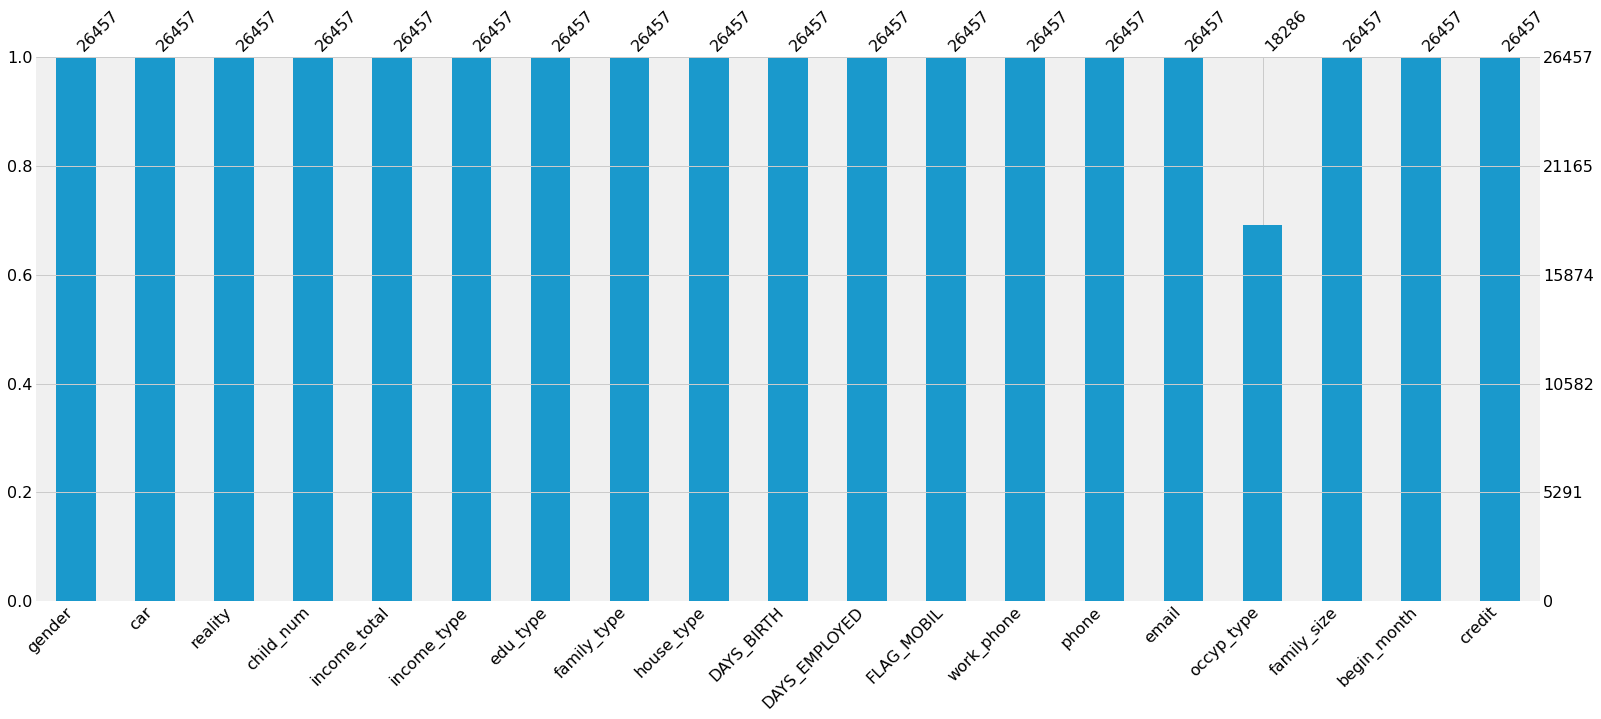

In [11]:
import missingno as msno
msno.bar(df=train.iloc[:, :], color=(0.1, 0.6, 0.8))

In [12]:
#NA Imputation
train = train.fillna({'occyp_type':'NA'})

### 2. 데이터 타입 변경


In [13]:
#gender, car, reality는 binary(object)

train['gender'] = train['gender'].apply(lambda x: 1 if x=='M' else 0) # Male=1, Female=0
train['car'] = train['car'].apply(lambda x: 1 if x=='Y' else 0) # Yes=1, No=0
train['reality'] = train['reality'].apply(lambda x: 1 if x=='Y' else 0) # Yes=1, No=0

In [14]:
#음수값을 양수값으로 
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].apply(lambda x: -x)
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(lambda x: -x)
train['begin_month'] = train['begin_month'].apply(lambda x: -x)

In [15]:
#DAYS_BIRTH로 나이 변수 만들어주기
train['Age'] = abs(train['DAYS_BIRTH'])/360
train = train.astype({'Age': 'int'})
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,Age
0,0,0,0,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,4709,1,0,0,0,NA,2.0,6.0,1.0,38
1,0,0,1,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,1540,1,0,0,1,Laborers,3.0,5.0,1.0,31
2,1,1,1,0,450000.0,Working,Higher education,Married,House / apartment,19087,4434,1,0,1,0,Managers,2.0,22.0,2.0,53
3,0,0,1,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,2092,1,0,1,0,Sales staff,2.0,37.0,0.0,41
4,0,1,1,0,157500.0,State servant,Higher education,Married,House / apartment,15037,2105,1,0,0,0,Managers,2.0,26.0,2.0,41


In [16]:
train['income_type'].unique()   

array(['Commercial associate', 'Working', 'State servant', 'Pensioner',
       'Student'], dtype=object)

In [17]:
train['edu_type'].unique()

array(['Higher education', 'Secondary / secondary special',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

In [18]:
train['family_type'].unique()  

array(['Married', 'Civil marriage', 'Separated', 'Single / not married',
       'Widow'], dtype=object)

In [19]:
train['house_type'].unique() 

array(['Municipal apartment', 'House / apartment', 'With parents',
       'Co-op apartment', 'Rented apartment', 'Office apartment'],
      dtype=object)

In [20]:
#라벨인코딩
from sklearn import preprocessing
enc = preprocessing.LabelEncoder()

train['income_type'] = enc.fit_transform(train['income_type'])
train['edu_type'] = enc.fit_transform(train['edu_type'])
train['family_type'] = enc.fit_transform(train['family_type'])
train['house_type'] = enc.fit_transform(train['house_type'])

### 3. 종속변수 확인하기
해당 대회는 credit을 예측하는 것이 목적
즉 credit 값이 종속변수, 다른 값들이 독립변수

In [21]:
train['credit'].unique() 
#0,1,2가 credit
#낮을 수록 높은 신용의 신용카드 사용자를 의미함 

array([1., 2., 0.])

In [22]:
train['credit'] = train['credit'].astype('object')

###4. 변수별 상관관계

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


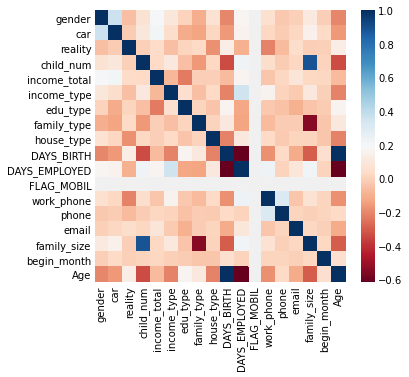

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize =(5,5))
corr = train.corr()
sns.heatmap(corr,cmap='RdBu')

✅child_num 과 family_size는 상관도가 매우 높음 -> 둘 중 하나 제거 필요->child_num 제거

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


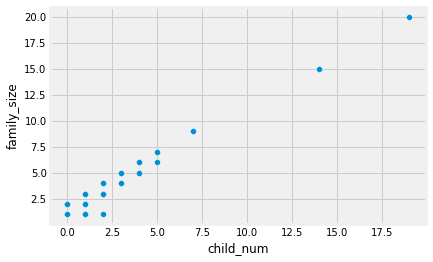

In [24]:
sns.scatterplot(x='child_num', y='family_size', data=train)

In [25]:
train = train.drop(['child_num'], axis=1)

### 5. 각 변수의 분포 살펴보기

####0. 종속변수

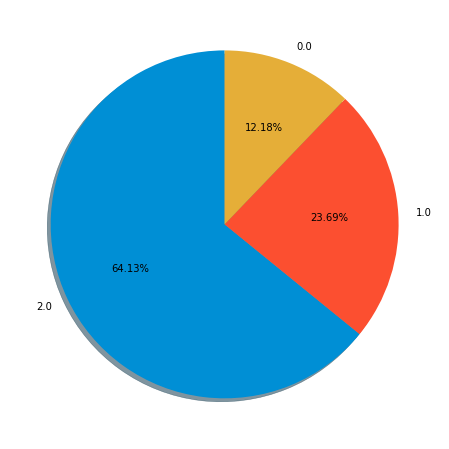

In [26]:
plt.subplots(figsize = (8,8))
plt.pie(train['credit'].value_counts(), labels = train['credit'].value_counts().index, 
        autopct="%.2f%%", shadow = True, startangle = 90)
plt.show()

####1. numerical 데이터

In [27]:
columns = ['income_total','DAYS_BIRTH','DAYS_EMPLOYED','family_size','begin_month']
train[columns].describe()

,income_total,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month
count,2.645700e+04,26457.000000,26457.000000,26457.000000,26457.000000
mean,1.873065e+05,15958.053899,-59068.750728,2.196848,26.123294
std,1.018784e+05,4201.589022,137475.427503,0.916717,16.559550
min,2.700000e+04,7705.000000,-365243.000000,1.000000,-0.000000
25%,1.215000e+05,12446.000000,407.000000,2.000000,12.000000
50%,1.575000e+05,15547.000000,1539.000000,2.000000,24.000000
75%,2.250000e+05,19431.000000,3153.000000,3.000000,39.000000
max,1.575000e+06,25152.000000,15713.000000,20.000000,60.000000


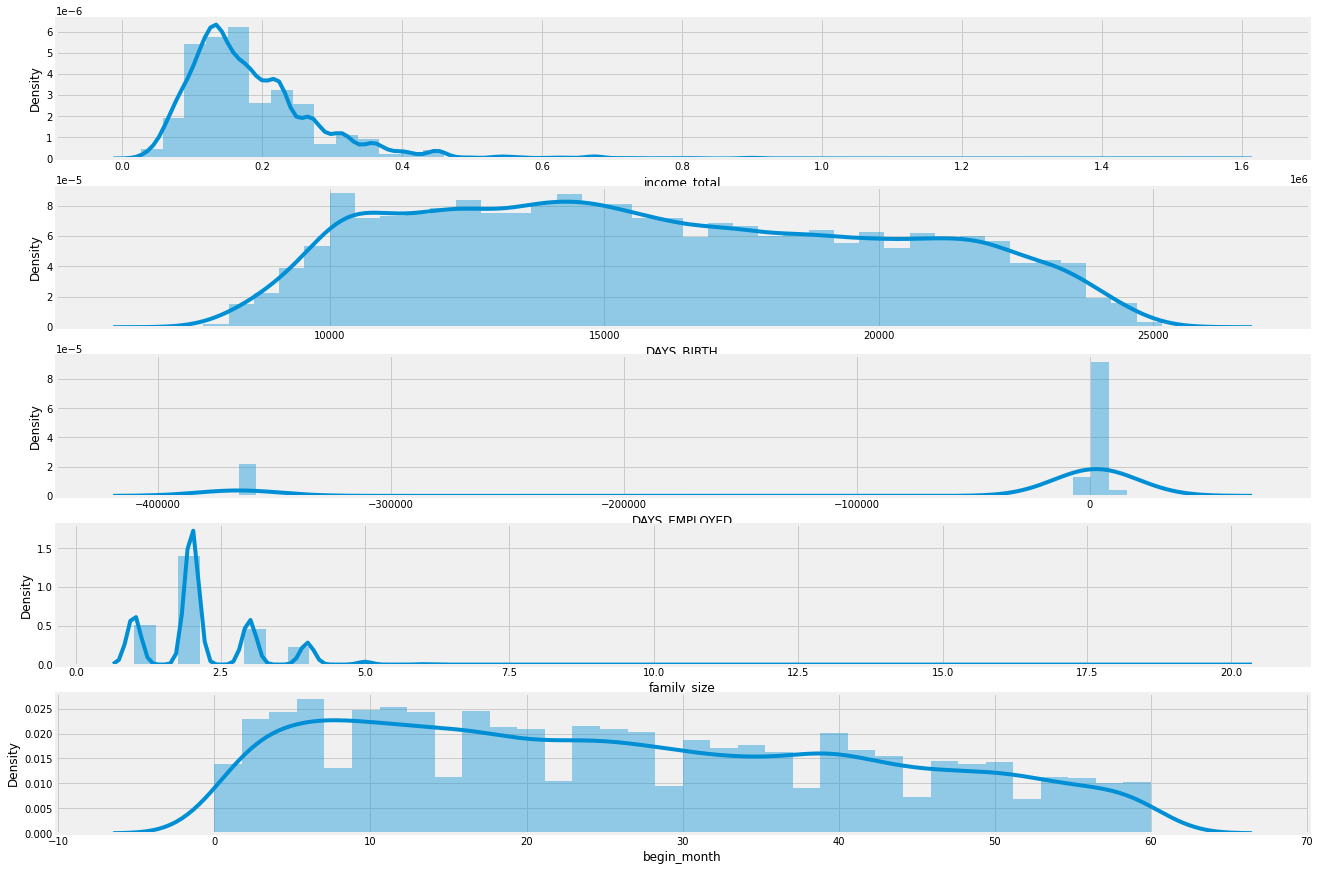

In [28]:
#'income_total','DAYS_BIRTH','DAYS_EMPLOYED','family_size','begin_month' 순

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (20,15))
for i in range(5):
    plt.subplot(5,1,i+1)
    sns.distplot(train[columns[i]])
plt.show()

수치 데이터를 살펴 보았을때, [income_total, DAYS,EMPLOYED, family_size] column이 skewed --> 정규화 필요 

In [29]:
#정규화 해보자
import numpy as np

reg = ['income_total', 'DAYS_EMPLOYED', 'family_size']
for i in reg :
    train[i] = ((train[i] - min(train[i]) / min(train[i]) - min(train[i])))

##### numerical 이상치 확인

In [30]:
def remove_outlier(train,column):
    df = train[column]
    # 1분위수
    quan_25 = np.percentile(df.values, 25)
    
    # 3분위수
    quan_75 = np.percentile(df.values, 75)
    
    iqr = quan_75 - quan_25
    
    lowest = quan_25 - iqr * 1.5
    highest = quan_75 + iqr * 1.5
    outlier_index = df[(df < lowest) | (df > highest)].index
    print('outlier의 수 : ' , len(outlier_index))
    train.drop(outlier_index, axis = 0, inplace = True)
    
    return train

In [31]:
for i in reg:  
    train = remove_outlier(train,i)
    
#len(train)

outlier의 수 :  1129
outlier의 수 :  5654
outlier의 수 :  301


✅ 이상치 제거 - 모델링 결과 보고 결정

####2. numerical(binary) 데이터

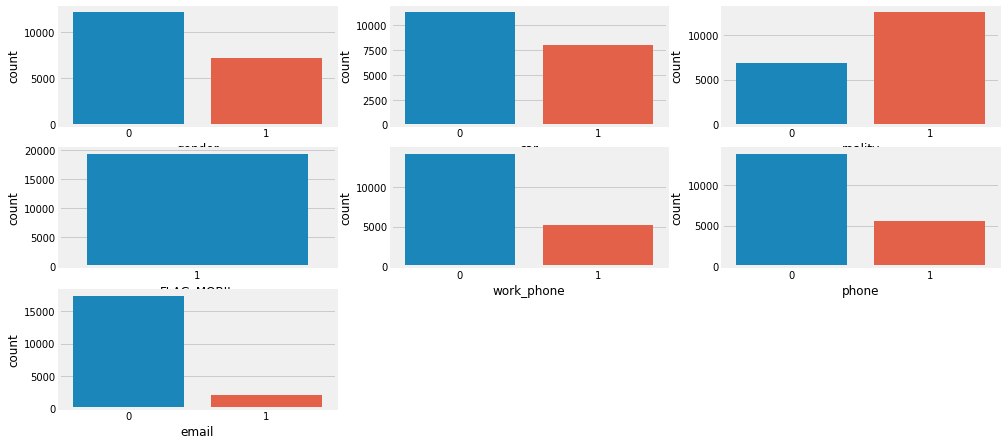

In [32]:
columns = ['gender','car','reality','FLAG_MOBIL','work_phone','phone','email']
import matplotlib.pyplot as plt

plt.figure(figsize = (15,10))
for i in range(7):
    plt.subplot(4,3,i+1)
    sns.countplot(train[columns[i]])
plt.show()

'FLAG_MOBIL'은 모든 값이 1이므로 삭제하기로 한다

In [33]:
train = train.drop(['FLAG_MOBIL'], axis=1)

'work_phone','phone','email'은 비슷한 정보를 담고 있는 column이므로 모델링 결과를 보며 조절하기로 한다

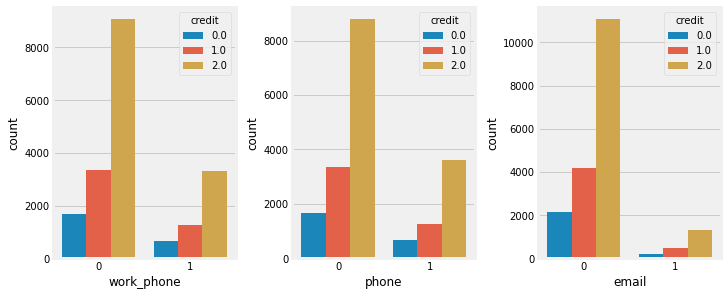

In [34]:
f, ax = plt.subplots(1, 3, figsize=(10,4), constrained_layout=True)

sns.countplot(x = 'work_phone', hue='credit', data=train, ax=ax[0])
sns.countplot(x = 'phone', hue='credit', data=train, ax=ax[1])
sns.countplot(x = 'email', hue='credit', data=train, ax=ax[2])

####3. categorical 데이터

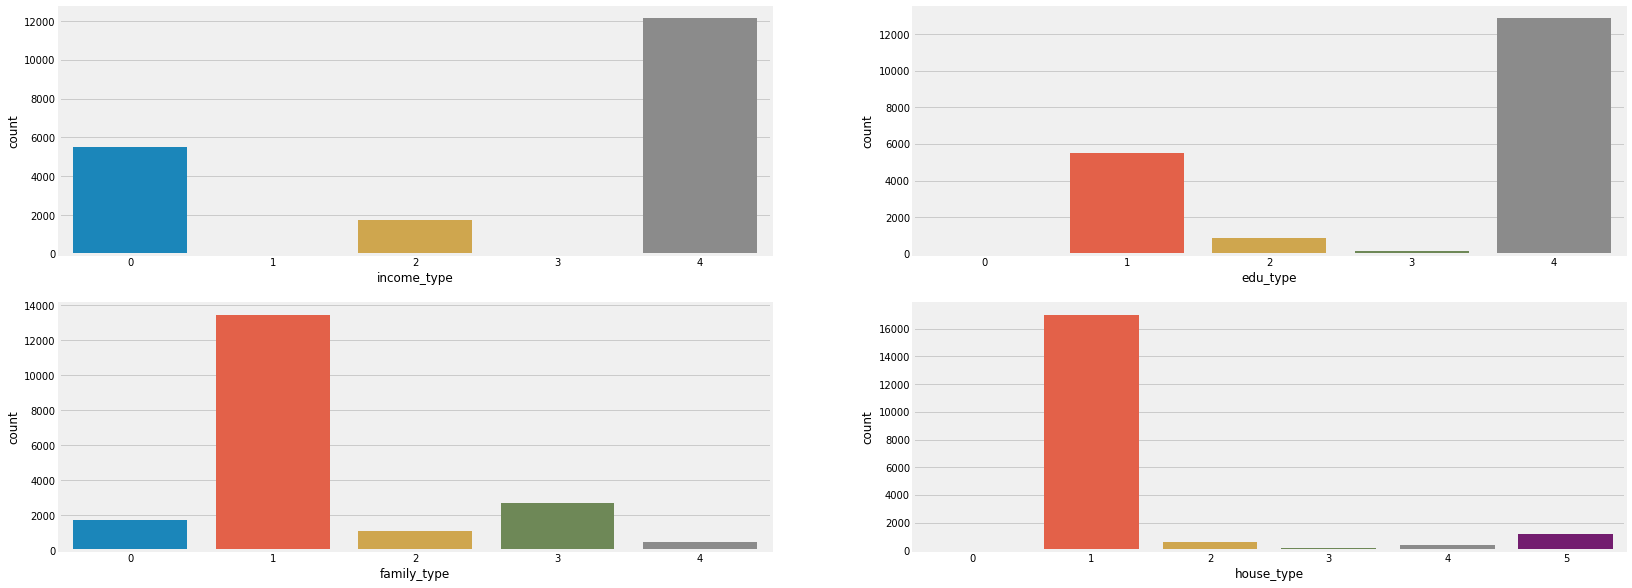

In [35]:
columns = ['income_type','edu_type','family_type','house_type']
import matplotlib.pyplot as plt

plt.figure(figsize = (25,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    sns.countplot(train[columns[i]])
plt.show()

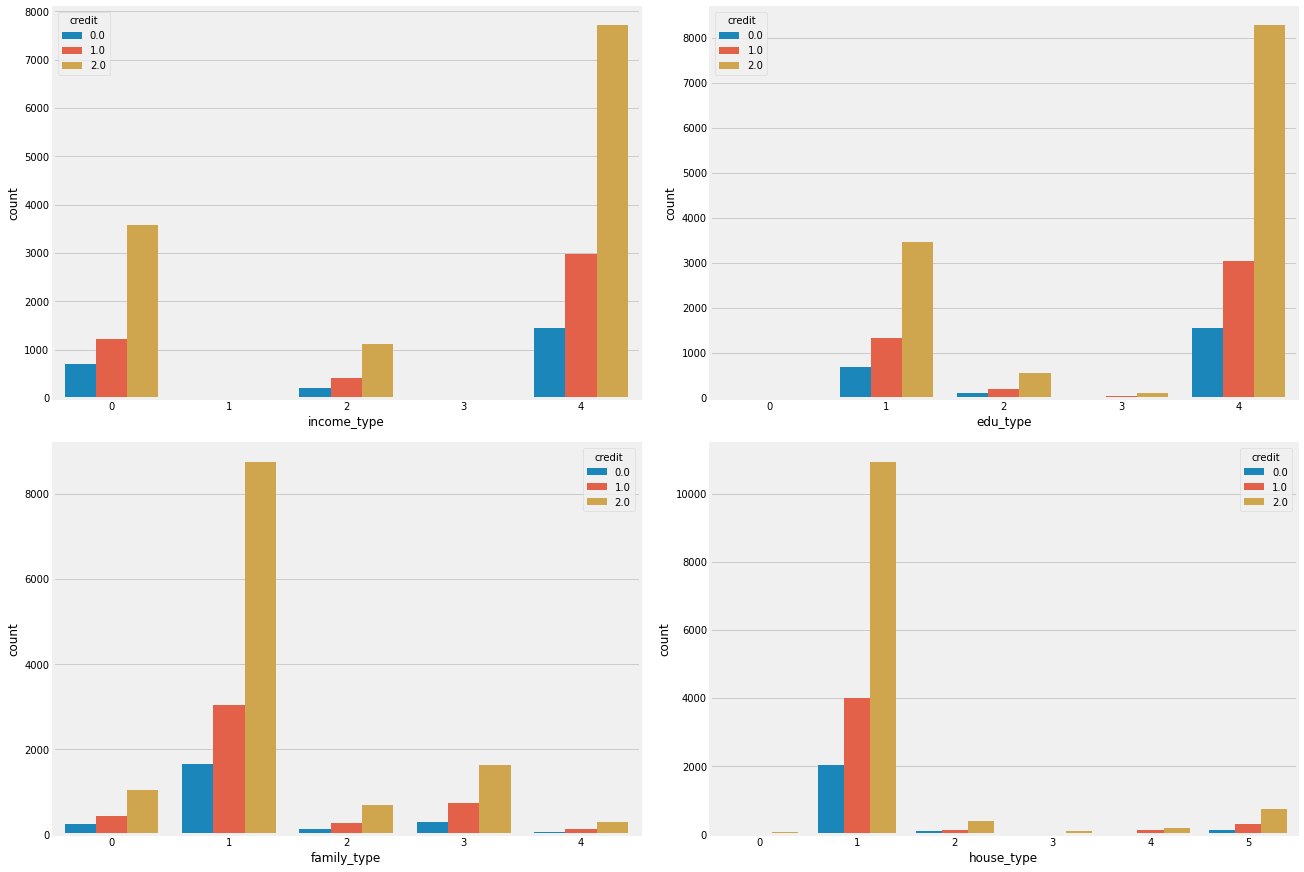

In [36]:
f, ax = plt.subplots(2, 2, figsize=(18,12), constrained_layout=True)

sns.countplot(x = 'income_type', hue='credit', data=train, ax=ax[0,0])
sns.countplot(x = 'edu_type', hue='credit', data=train, ax=ax[0,1])
sns.countplot(x = 'family_type', hue='credit', data=train, ax=ax[1,0])
sns.countplot(x = 'house_type', hue='credit', data=train, ax=ax[1,1])

###전처리 완료된 train 데이터 불러오기

In [37]:
train

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,Age
0,0,0,0,175499.0,0,1,1,2,13899,369951.0,0,0,0,NA,0.0,6.0,1,38
1,0,0,1,220499.0,0,4,0,1,11380,366782.0,0,0,1,Laborers,1.0,5.0,1,31
3,0,0,1,175499.0,0,4,1,1,15088,367334.0,0,1,0,Sales staff,0.0,37.0,0,41
4,0,1,1,130499.0,2,1,1,1,15037,367347.0,0,0,0,Managers,0.0,26.0,2,41
5,0,0,1,242999.0,4,4,1,1,13413,370238.0,0,0,1,High skill tech staff,2.0,18.0,1,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0,0,0,197999.0,2,4,1,1,12079,367226.0,0,0,0,Core staff,2.0,2.0,1,33
26453,0,0,1,152999.0,4,1,2,1,15291,367717.0,0,0,0,NA,0.0,47.0,2,42
26454,0,1,0,265499.0,4,4,0,5,10082,367257.0,0,0,0,Core staff,0.0,25.0,2,28
26455,1,0,1,143999.0,4,2,3,1,10145,365349.0,0,0,0,Laborers,-1.0,59.0,2,28
